In [311]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import os
import time

In [2]:
os.getcwd()

'C:\\Users\\nvolf\\Google Drive 2\\5th Year (Masters) Modules\\Third Semester'

In [95]:
default_backend = 'module://ipykernel.pylab.backend_inline'

# X-Model

In this notebook, we attempt to replicate the general method in the following article: <a href="https://arxiv.org/pdf/1509.00372.pdf">Electricity Price Forecasting using Sale and Purchase Curves: The X-Model</a>.

### The Method:
The basic idea is to view the bid and supply volumes as processes in time. We model these processes and forecast the price by finding the 'intersection' of these two curves at any given time. The general steps are as follows:
   1. <b>Create price classes</b> (dimension reduction) to make the modelling and forecasting process computationally feasible.
   2. <b>Design and train the (time series) model to forecast bid volume processes</b>
   3. <b>Forecast future bid volumes, reconstruct original price curves, then determine corresponding prices</b>

### Some things to note:
1. The article implements the method on EPEXSPOT DAM data for Germany and Austria. We are (initially) implementing the method on EPEXSPOT DAM data for Ireland (excluding Northern Ireland).
2. The ultimate goal here is to provide forecasts for the electricity price based on the model. As we progress through the notebook, some sections were written for illustration purposes or for explaining something about the data.
3. Some of the functions were designed with more parameters/functionalities than is necessary for the task at hand, but in expectation of potentially expanding the method, we try to make the functions as flexible and adaptable as we can.
4. When referring to the demand and supply curves, we use interchangeable terms, i.e. 'price' curves, 'supply'/'sell'/'sale' curve, 'demand'/'purchase' curve.

### Load data

In [3]:
path_ba1 = "Datasets/BidAskCurvve1.csv"
path_ba2 = "Datasets/BidAskCurvve2.csv"
path_ba3 = "Datasets/BidAskCurvve3.csv"

In [4]:
ba1 = pd.read_csv(path_ba1)
ba2 = pd.read_csv(path_ba2)
ba3 = pd.read_csv(path_ba3)

### Combine data

In [5]:
ba = ba1.append(ba2.append(ba3, ignore_index=True), ignore_index=True)

### Verify data integrity and clean data (ensure consistent data types, remove duplicate days/hours, sort by delivery date/time)

Note: Daylight Savings Time adjustments are applied in the modelling step (2).

In [6]:
def clean_TimeStepID(TimeStepID):
    # If no need to edit, return the same value
    if type(TimeStepID) == int:
        return(TimeStepID)
    
    # Remove letter/s
    if re.search(".*B$", TimeStepID):
        pos = re.search("B", TimeStepID).start()
    else:
        return(int(TimeStepID))
    
    # Remove letter and convert to int
    return(int(TimeStepID[:pos]))

def clean_data(dataframe):
    # Remove duplicates
    dataframe = dataframe.drop_duplicates()
    
    # Ensure data types are consistent, i.e. DeliveryDay is date, TimeStepID is int, etc.
    dataframe["DeliveryDay"] = pd.to_datetime(dataframe["DeliveryDay"], format="%Y-%m-%d")   
    dataframe["TimeStepID"] = dataframe["TimeStepID"].apply(clean_TimeStepID)
    dataframe = dataframe.sort_values(by=["DeliveryDay","TimeStepID"]).reset_index().drop("index", axis=1)

    return(dataframe)

In [7]:
ba = clean_data(ba)

c:\users\nvolf\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\nvolf\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Get Price Curve

We define function to fetch price curve for a given index in the bid ask dataframe

In [651]:
def get_price_curves(dataframe, index, return_vals="both", aggregated=False, plot=False, xlim=None, ylim=None):
    # Extract bid volumes and corresponding bid prices for that delivery hour
    pv = list(map(float,dataframe.loc[index,"PurchaseVolume"].split(",")))
    sv = list(map(float,dataframe.loc[index,"SellVolume"].split(",")))
    pp = list(map(float, dataframe.loc[index,"PurchasePrice"].split(",")))
    sp = list(map(float,dataframe.loc[index,"SellPrice"].split(",")))
    
    
    # Combine bid data and supply data into their own dataframes, and add a column of aggregated volume to each df.
    if return_vals == "purchase":
        purchase = pd.DataFrame(dict(PurchaseVolume=pv, PurchasePrice=pp)).sort_values(by="PurchasePrice", ascending=False)
        if aggregated:
            purchase["AggregatedPurchaseVolume"] = purchase[["PurchaseVolume"]].cumsum()
        
    elif return_vals == "sell":
        sell = pd.DataFrame(dict(SellVolume=sv, SellPrice=sp)).sort_values(by="SellPrice")
        if aggregated:
            sell["AggregatedSellVolume"] = sell[["SellVolume"]].cumsum()
        
    elif return_vals == "both":
        purchase = pd.DataFrame(dict(PurchaseVolume=pv, PurchasePrice=pp)).sort_values(by="PurchasePrice", ascending=False)
        sell = pd.DataFrame(dict(SellVolume=sv, SellPrice=sp)).sort_values(by="SellPrice")
        
        if aggregated:
            purchase["AggregatedPurchaseVolume"] = purchase[["PurchaseVolume"]].cumsum()
            sell["AggregatedSellVolume"] = sell[["SellVolume"]].cumsum()
    
    # For illustration (and confirmation of expectations)
    if plot and aggregated:
        xlim = (purchase["AggregatedPurchaseVolume"].min(),
                purchase["AggregatedPurchaseVolume"].max()) if xlim==None else xlim
        ylim = (-100, 300) if ylim==None else ylim
        ax = purchase.drop(["PurchaseVolume"], axis=1).plot(x="AggregatedPurchaseVolume")
        sell.drop(["SellVolume"], axis=1).plot(x="AggregatedSellVolume", ax=ax)
        ax.set_xlabel("Volume")
        ax.set_ylabel("Price")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    
    if plot and not aggregated:
        print("Warning: cannot plot if aggregated=False")
           
    # Return the purchase/sell curve data
    if return_vals == "purchase":
        return(purchase) 
    elif return_vals == "sell":
        return(sell)
    elif return_vals == "both":
        return(purchase, sell)

Mathematical formula for supply and demand curves:

\begin{equation}
        S_t(P) = \mathop{\sum\limits_{p \in \mathbb{P}_{S,t}}}_{p \leq P} V_{S,t}(p) \text{ for } P \in \mathbb{P}_{S,t} \text{ and }
        D_t(P) = \mathop{\sum\limits_{p \in \mathbb{P}_{D,t}}}_{p \geq P} V_{D,t}(p) \text{ for } P \in \mathbb{P}_{D,t} 
\end{equation}

Sample supply and demand curve for a given hour:

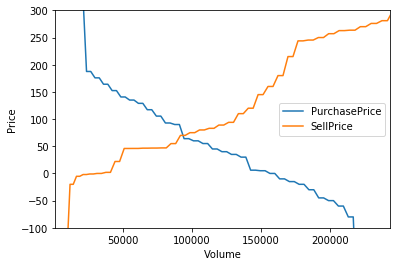

In [33]:
bid_curve, ask_curve = get_price_curves(ba, 0, plot=True, aggregated=True)

### 1. Construct Price Classes

EPEX SPOT prices range between -500 and 3000, in increments of 0.1, e.g. $\mathbb{P} = \{-500.0,-499.9,-499.8\ldots,2999.7, 2999.8,2999.9,3000.0\}$, so there are 35,001 possible prices. If computational expense was not an issue, then we would model the bid volume of each price point in time, giving us two price processes (demand and supply) each consisting of 35,001 components. Of course, the majority of these prices will almost always be 0. Because of this, and for computational feasibility, we implement a simple dimension reduction technique of grouping the bid volumes by price class.

The method outline is as follows:
   1. <b>Calculate mean bid volumes per price across the whole time range spanned by our dataset.</b> Note: we exclude prices that were always 0, e.g. if no bid was ever made for the price -461.5, then we don't include this in the dataframe, as it will be implicitly processed as a 0 anyway.
   2. <b>Construct a supply and demand curve from the mean bid volumes</b> as we did above.
   3. <b>Use equidistant volume classes to determine the lengths of the price classes</b>. We will give a visual representation of this later.

So firstly, we calculate the mean bid volumes. We will use the above function `get_price_curves()` to help us.

In [44]:
# This takes a while to run as it will loop through thousands of rows
def get_mean_volumes(dataframe, start_index=0, end_index=-1, price_curve="both"):
    n = dataframe.shape[0]
    end_index = n if end_index == -1 else end_index
    
    # Create dataframes for combining hourly purchase and sell bids
    combined_purchase = pd.DataFrame(columns=["PurchaseVolume", "PurchasePrice"])
    combined_sell = pd.DataFrame(columns=["SellVolume", "SellPrice"])
    
    # Combine the bids
    for i in range(start_index, end_index):
        hourly_purchase, hourly_sell = get_price_curves(ba, i)
        combined_purchase = combined_purchase.append(hourly_purchase, ignore_index=True)
        combined_sell = combined_sell.append(hourly_sell, ignore_index=True)
    
    # Calculate the mean volumes across each distinct price. Note: we divide by n rather than using .mean() function
    # since there are many times when a volume for a given price is 0. The .mean() function does not take this into account,
    # and we want to include the 0 values in the calculation of the mean.
    mean_purchase = combined_purchase.groupby(["PurchasePrice"]).sum()/n
    mean_sell = combined_sell.groupby(["SellPrice"]).sum()/n
    
    return(mean_purchase, mean_sell)

Values were stored beforehand to make running easier. The commented code takes a few minutes to run. Make sure to run that first and store it in your computer using the next cell.

In [286]:
mean_purchase = pd.read_csv("Variables/mean_purchase.csv", index_col="PurchasePrice")
mean_sell = pd.read_csv("Variables/mean_sell.csv", index_col="SellPrice")

# start_time = time.time()
# mean_purchase, mean_sell = get_mean_volumes(ba)
# print(f"Execution time: {time.time() - start_time} seconds")

Store the mean bid volumes in local directory to save time in future runs.

In [72]:
if not os.path.exists("Variables"):
    os.mkdir("Variables")

mean_purchase.to_csv("Variables/mean_purchase.csv")
mean_sell.to_csv("Variables/mean_sell.csv")

Here, we create the 'aggregated' volumes for the (average) supply and demand data, giving us the mean supply and demand curves.

In [73]:
def to_price_curve(bid_dataframe, curve_type):
    # Sort dataframe by prices (increasing order for supply curve, decreasing order for demand curve)
    if curve_type == "sell":
        sorted_bid_dataframe = bid_dataframe.sort_values(by=["SellPrice"], ascending=True)
    elif curve_type == "purchase":
        sorted_bid_dataframe = bid_dataframe.sort_values(by=["PurchasePrice"], ascending=False)

    # Calculate cumulative volumes
    column_name = "PurchaseVolume" if curve_type == "purchase" else "SellVolume"
    agg_column_name = "AggregatedPurchaseVolume" if curve_type == "purchase" else "AggregatedSellVolume"
    
    sorted_bid_dataframe[agg_column_name] = sorted_bid_dataframe[column_name].cumsum()
    
    return(sorted_bid_dataframe)

In [74]:
mean_purchase_curve = to_price_curve(mean_purchase, curve_type="purchase")
mean_sell_curve = to_price_curve(mean_sell, curve_type="sell")

This function is just for illustration (and to confirm visually that we did it correctly)

In [76]:
def plot_price_curves(purchase, sell, xlim=None, ylim=None, classes=None, linewidth=0.8):
    xlim = (0, max(purchase[["AggregatedPurchaseVolume"]].max()[0],
                  sell[["AggregatedSellVolume"]].max()[0])) if xlim == None else xlim
    ylim = (-500,3000) if ylim == None else ylim
    
    ax = purchase.drop(["PurchaseVolume"], axis=1).reset_index().plot(y=["PurchasePrice"], x="AggregatedPurchaseVolume")
    sell.drop(["SellVolume"], axis=1).reset_index().plot(y=["SellPrice"], x="AggregatedSellVolume", ax=ax, xlim=xlim, ylim=ylim)
    ax.set_ylabel("Price"); ax.set_xlabel("Mean Volume")
    
    if classes is not None:
        purchase_classes, sell_classes = classes
        
        for points in purchase_classes.values:
            volume = points[0]
            price = points[1]
            
            ax.hlines(price, xmin=0, xmax=volume, color="blue", linestyle="--", linewidth=linewidth)
            ax.vlines(volume, ymin=-500, ymax=price, color="blue", linestyle="--", linewidth=linewidth)
            
        for points in sell_classes.values:
            volume = points[0]
            price = points[1]
            
            ax.hlines(price, xmin=0, xmax=volume, color="orange", linestyle="--", linewidth=linewidth)
            ax.vlines(volume, ymin=-500, ymax=price, color="orange", linestyle="--", linewidth=linewidth)    
    
    plt.show()

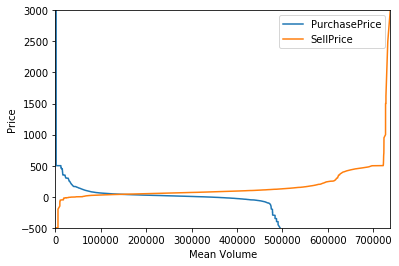

In [77]:
plot_price_curves(mean_purchase_curve, mean_sell_curve)#, ylim=(-60,180))

It kind of looks right...

Now that we have the mean supply and demand curves for the period, we can finally create our price classes.

<b>Main idea:</b> Because the price curves are monotonic, we can use the inverse function of the price curves to get a distinct price for every given volume amount.

Note: It is theoretically possible to get the same price class more than once, e.g. for a completely horizontal curve. However, our choice of volume class length is large enough that this will not happen in practice.

In [223]:
""" Each purchase (demand) curve price class is determined by its lower bound, and
    each sell (supply) curve price class is determined by its upper bound.
    
    The class_length parameter can be chosen arbitrarily or with some justification. Our choice of 31000 is to so
    that we have a similar number of classes as in the paper (which had 16 purchase/sell classes).
"""
def create_price_classes(mean_purchase_curve, mean_sell_curve, class_length=31000, decimals=2):
    # Initialise and prepare price class dataframes.
    purchase_df = mean_purchase_curve.drop("PurchaseVolume", axis=1)
    sell_df = mean_sell_curve.drop("SellVolume", axis=1)

    purchase_classes = pd.DataFrame(columns=["Volume", "Price"])
    sell_classes = pd.DataFrame(columns=["Volume","Price"])
    
    purchase_classes = purchase_classes.append(dict(Volume=purchase_df.iloc[0,0], Price=purchase_df.index[0]), ignore_index=True)
    sell_classes = sell_classes.append(dict(Volume=sell_df.iloc[0,0], Price=sell_df.index[0]), ignore_index=True)
    
    
    # Populate demand price class dataframe
    volume_class_increment = 1
    for i in range(1, purchase_df.shape[0]):
        new_volume_class_bound = volume_class_increment * class_length
        
        if new_volume_class_bound == purchase_df.iloc[i, 0]:
            purchase_classes = purchase_classes.append(dict(Volume=new_volume_class_bound, Price=purchase_df.index[i]))
        
        elif new_volume_class_bound < purchase_df.iloc[i, 0]:
            previous_price = purchase_df.index[i-1]
            current_price = purchase_df.index[i]
            previous_volume = purchase_df.iloc[i-1, 0]
            current_volume = purchase_df.iloc[i, 0]
            
            # Linear interpolation between current price and previous price
            price_diff = current_price - previous_price
            volume_diff = current_volume - previous_volume
            new_price_class_bound = previous_price + (price_diff/volume_diff)*(new_volume_class_bound-previous_volume)
            purchase_classes = purchase_classes.append(dict(Volume=new_volume_class_bound, Price=round(new_price_class_bound, decimals)), ignore_index=True)
        else:
            continue
            
        volume_class_increment += 1
    
    
    # Populate supply price class dataframe
    volume_class_increment = 1
    for i in range(1, sell_df.shape[0]):
        new_volume_class_bound = volume_class_increment * class_length
        
        if new_volume_class_bound == sell_df.iloc[i, 0]:
            sell_classes = sell_classes.append(dict(Volume=new_volume_class_bound, Price=sell_df.index[i]), ignore_index=True)
        
        elif new_volume_class_bound < sell_df.iloc[i, 0]:
            previous_price = sell_df.index[i-1]
            current_price = sell_df.index[i]
            previous_volume = sell_df.iloc[i-1, 0]
            current_volume = sell_df.iloc[i, 0]
            
            # Linear interpolation between current price and previous price
            price_diff = current_price - previous_price
            volume_diff = current_volume - previous_volume
            new_price_class_bound = previous_price + (price_diff/volume_diff)*(new_volume_class_bound-previous_volume)
            sell_classes = sell_classes.append(dict(Volume=new_volume_class_bound, Price=round(new_price_class_bound, decimals)), ignore_index=True)
        else:
            continue
            
        volume_class_increment += 1
    
    purchase_classes = purchase_classes.append(dict(Volume=purchase_df.iloc[purchase_df.shape[0]-1,0], Price=round(purchase_df.index[-1], decimals)), ignore_index=True)
    sell_classes = sell_classes.append(dict(Volume=sell_df.iloc[sell_df.shape[0]-1,0], Price=round(sell_df.index[-1], decimals)), ignore_index=True)
    
    return(purchase_classes, sell_classes)

In [224]:
purchase_classes, sell_classes = create_price_classes(mean_purchase_curve, mean_sell_curve)

In [227]:
print("# of purchase curve price classes:", len(purchase_classes))
print("# of sale curve price classes:", len(sell_classes))

# of purchase curve price classes: 17
# of sale curve price classes: 25


Below are the resulting price classes. Note: For the demand curve, prices indicate the lower bound of a price class, and prices for the supply curve indicate the upper bound.

In [228]:
purchase_classes.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Volume,1512.67047,31000.00,62000.00,93000.00,124000.00,155000.00,186000.00,217000.00,248000.00,279000.00,310000.00,341000.00,372000.0,403000.0,434000.00,465000.00,494647.406536
Price,3000.00000,250.02,112.65,65.11,47.46,36.19,28.37,21.91,15.52,9.41,1.94,-5.31,-16.1,-30.6,-49.99,-91.49,-500.000000


In [229]:
sell_classes.T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Volume,1812.920143,31000.0,62000.0,93000.00,124000.00,155000.00,186000.0,217000.0,248000.00,279000.00,...,465000.0,496000.0,527000.0,558000.00,589000.00,620000.00,651000.00,682000.00,713000.00,737369.642226
Price,-500.000000,-10.0,5.0,25.87,34.17,41.02,47.0,52.9,58.99,64.99,...,112.1,125.2,144.0,169.29,217.52,299.99,434.01,471.47,499.25,3000.000000


The code below provides a visualisation of how the price classes are built using equidistant volume classes. Doing this allows us to take into account the fact that most bids are made at certain price ranges.

<IPython.core.display.Javascript object>


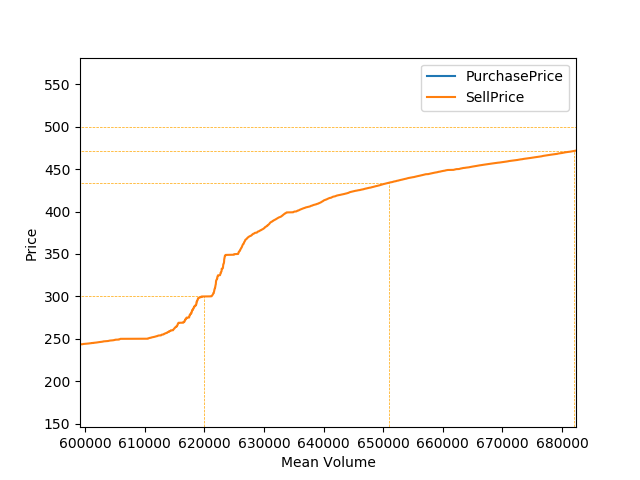

In [104]:
%matplotlib nbagg
plot_price_curves(mean_purchase_curve, mean_sell_curve, classes=(purchase_classes, sell_classes), linewidth=0.5)

First, we will transform the data. For each price class, we add up all the bid volumes for prices within that price class.

In [315]:
def reduce_bid_ask_data(bid_ask_dataframe, purchase_classes, sell_classes):
    # Initialise and prepare dataframes
    identifier_columns = ["DeliveryDay", "TimeStepID"]
    purchase_columns = identifier_columns + list(purchase_classes["Price"])
    sell_columns = identifier_columns + list(sell_classes["Price"])
    
    purchase_reduced_df = pd.DataFrame(columns=purchase_columns)
    sell_reduced_df = pd.DataFrame(columns=sell_columns)
    
    purchase_reduced_df[identifier_columns] = bid_ask_dataframe[identifier_columns]
    purchase_reduced_df = purchase_reduced_df.fillna(0)
    sell_reduced_df[identifier_columns] = bid_ask_dataframe[identifier_columns]
    sell_reduced_df = sell_reduced_df.fillna(0)
    
    # Populate price classes with bid volumes
    for time_step in range(bid_ask_dataframe.shape[0]):
        purchase_df, sell_df = get_price_curves(bid_ask_dataframe, time_step)
        purchase_df = purchase_df.reset_index().drop("index", axis=1)
        
        purchase_classes_index = sell_classes_index = 0
        
        
        current_purchase_class = purchase_classes.loc[purchase_classes_index, "Price"]
        for i in range(len(purchase_df)):
            current_purchase_price = purchase_df.loc[i, "PurchasePrice"]
            
            while(current_purchase_class > current_purchase_price):
                purchase_classes_index += 1
                try:
                    current_purchase_class = purchase_classes.loc[purchase_classes_index, "Price"]
                except Exception as e:
                    print(current_purchase_class, current_purchase_price)
                    throw(e)
            
            purchase_reduced_df.loc[time_step, current_purchase_class] += purchase_df.loc[i, "PurchaseVolume"]
            
            
        current_sell_class = sell_classes.loc[sell_classes_index, "Price"]
        for j in range(len(sell_df)):
            current_sell_price = sell_df.loc[j, "SellPrice"]
            
            while(current_sell_class < current_sell_price):
                sell_classes_index += 1
                current_sell_class = sell_classes.loc[sell_classes_index, "Price"]
            
            sell_reduced_df.loc[time_step, current_sell_class] += sell_df.loc[j, "SellVolume"]
            
    return(purchase_reduced_df, sell_reduced_df)

Once again, this function takes a while to run, so we store the variables in local directory.

In [374]:
ba_purchase_reduced = pd.read_csv("Variables/ba_purchase_reduced.csv", index_col="Unnamed: 0")
ba_sell_reduced = pd.read_csv("Variables/ba_sell_reduced.csv", index_col="Unnamed: 0")

# start_time = time.time()
# ba_purchase_reduced, ba_sell_reduced = reduce_bid_ask_data(ba, purchase_classes, sell_classes)
# print(f"Execution time: {time.time() - start_time} seconds")

In [318]:
if not os.path.exists("Variables"):
    os.mkdir("Variables")

ba_purchase_reduced.to_csv("Variables/ba_purchase_reduced.csv")
ba_sell_reduced.to_csv("Variables/ba_sell_reduced.csv")

Now, we make the Daylight Savings Time adjustments to the data to deal with days that have 23 or 25 hours.

In [878]:
# Function to find the specific hour (TimeStepID) that is either duplicated (for 25-hour days) or is missing (for 23-hour days).
# The usual DST is for hour 3, i.e. either two rows for hour 3, or no hour 3 at all, but we make the function a bit more flexible.
def find_dst_index(time_step_id_dataframe, number_of_hours):
    if number_of_hours == 23:
        for i, time_step_id in enumerate(time_step_id_dataframe):
            if i+1 < time_step_id:
                return(i+1)
            elif i == number_of_hours:
                return(24)
                
    elif number_of_hours == 25:
        for j, time_step_id in enumerate(time_step_id_dataframe):
            if j+1 > time_step_id:
                return(time_step_id)

# Function to ensure that bid data consists of 24 hours per day. For 23-hour days, the extra day is added by interpolating
# the bid data between the previous and next hour. For 25-hour days, we replace the duplicate hours by getting the average.
def dst_adjustment(reduced_bid_df):
    # Fetch the list of DST days - If we did our pre-processing correctly in previous sections,
    # this dataframe should only have values of 23 and 25.
    dst_dates = reduced_bid_df.groupby("DeliveryDay").count().loc[(reduced_bid_df.groupby("DeliveryDay").count()["TimeStepID"] != 24),:]["TimeStepID"]
    dst_dates.rename("NumberOfHours", inplace=True)
    
    for i in range(dst_dates.shape[0]):
        dst_date = dst_dates.index[i]
        number_of_hours = dst_dates[i]
        
        # Get the (reduced) bid data for the specific dst_date
        reduced_bid_dst_data = reduced_bid_df.loc[reduced_bid_df["DeliveryDay"] == dst_date,:]
        
        # Find the specific hour that's either duplicated (for 25-hour days) or missing (for 23-hour days).
        dst_index = find_dst_index(reduced_bid_dst_data["TimeStepID"], number_of_hours)
        
        # If 23-hour day, get the average of the bid data for the adjacent hours.
        if number_of_hours == 23:
            # Fetch adjacent bids, e.g. if missing bid is for 3rd hour, then we fetch bids for 2nd and 4th hour.
            previous_bid = reduced_bid_dst_data.loc[reduced_bid_dst_data["TimeStepID"] == dst_index-1]
            next_bid = reduced_bid_dst_data.loc[reduced_bid_dst_data["TimeStepID"] == dst_index+1]
            adjacent_bids = previous_bid.append(next_bid).drop(["DeliveryDay", "TimeStepID"], axis=1)
            
            # Calculate the average of the two hours of bid data
            average_values = adjacent_bids.mean(axis=0).rename(reduced_bid_df.shape[0]-1).to_frame().T
            
            # Insert this new bid into the original dataframe containing reduced bid data.
            identifiers = pd.DataFrame(dict(DeliveryDay=dst_date, TimeStepID=dst_index), index=[reduced_bid_df.shape[0]-1])
            new_bid = pd.concat([identifiers, average_values], axis=1)
            reduced_bid_df = reduced_bid_df.append(new_bid)
        
        # If 25-hour day, replace the two duplicate hours with their average
        elif number_of_hours == 25:
            # Fetch duplicate bids
            duplicate_bids = reduced_bid_dst_data.loc[reduced_bid_dst_data["TimeStepID"] == dst_index]
            duplicate_bids.drop(["DeliveryDay", "TimeStepID"], axis=1, inplace=True)
            
            # Calculate the average of the two hours of bid data
            average_values = duplicate_bids.mean(axis=0).rename(reduced_bid_df.shape[0]-1).to_frame().T
            
            # Insert this new bid into the original dataframe containing reduced bid data.
            identifiers = pd.DataFrame(dict(DeliveryDay=dst_date, TimeStepID=dst_index), index=[reduced_bid_df.shape[0]-1])
            new_bid = pd.concat([identifiers, average_values], axis=1)
            reduced_bid_df = reduced_bid_df.append(new_bid)
            
            # Delete the two rows of duplicate hours
            reduced_bid_df.drop(duplicate_bids.index, inplace=True)

    # Sort the dataframe so that the bid data is arranged in its proper order
    reduced_bid_df.sort_values(by=["DeliveryDay", "TimeStepID"], inplace=True)
    reduced_bid_df["DeliveryDay"] = pd.to_datetime(reduced_bid_df["DeliveryDay"], format="%Y-%m-%d")
        
    return(reduced_bid_df)

In [931]:
ba_purchase_reduced_dst = dst_adjustment(ba_purchase_reduced)
ba_sell_reduced_dst = dst_adjustment(ba_sell_reduced)

c:\users\nvolf\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### 2. Design and Train the Model to Forecast Bid Volume Processes

There's more freedom 

At this point

1. <b>Reduce the demand/supply data</b> using the price classes previously created.
2. <b>Make adjustments for DST</b>: For 25-hour days, we will use the average of the two hours; for 23-hour days, we interpolate between adjacent hours to get 24 data points.
3. <b> Design the model </b>
4. <b> Prepare data for training </b>
5. <b> Train the model </b>

The bid volume structure is influenced by what day of the week it is. In particular, we see lower bid volumes for weekends. The next bit of code will be used to show this difference in bid structure from day to day.

In [856]:
# Function to calculate mean bid volume over ther period for demand/supply per hour, per day of the week,
# giving us a 24x7 table (24 hours, 7 days).
def get_mean_day_volumes(dataframe, start_index=0, end_index=-1):
    n = dataframe.shape[0]
    end_index = n if end_index == -1 else end_index
    
    new_dataframe = dataframe.copy()
    new_dataframe.insert(2, "DayOfWeek", new_dataframe["DeliveryDay"].dt.dayofweek)
    new_dataframe.drop("DeliveryDay", axis=1)
    
    common_columns = ["TimeStepID", "DayOfWeek"]
    purchase_hourly_volumes = pd.DataFrame(columns=common_columns+["TotalPurchaseVolume"])
    sell_hourly_volumes = pd.DataFrame(columns=common_columns+["TotalSellVolume"])
    
    purchase_hourly_volumes[common_columns] = new_dataframe[common_columns]
    sell_hourly_volumes[common_columns] = new_dataframe[common_columns]
    
    purchase_hourly_volumes.fillna(0, inplace=True)
    sell_hourly_volumes.fillna(0, inplace=True)
    
    
    for i in range(n):
        purchase, sell = get_price_curves(new_dataframe, i)  
        purchase_hourly_volumes.loc[i, "TotalPurchaseVolume"] = purchase["PurchaseVolume"].sum()
        sell_hourly_volumes.loc[i, "TotalSellVolume"] = sell["SellVolume"].sum()
    
    sum_hourly_purchase = purchase_hourly_volumes.groupby(["DayOfWeek", "TimeStepID"]).mean()
    sum_hourly_sell = sell_hourly_volumes.groupby(["DayOfWeek", "TimeStepID"]).mean()
    
    ordered_hourly_purchase = pd.DataFrame(columns=pd.unique(sum_hourly_purchase.index.get_level_values("DayOfWeek")), index=pd.unique(sum_hourly_purchase.index.get_level_values("TimeStepID")))
    ordered_hourly_sell = pd.DataFrame(columns=pd.unique(sum_hourly_sell.index.get_level_values("DayOfWeek")), index=pd.unique(sum_hourly_sell.index.get_level_values("TimeStepID")))
    
    for column in ordered_hourly_purchase.columns:
        ordered_hourly_purchase[column] = sum_hourly_purchase.loc[column,:,]
        ordered_hourly_sell[column] = sum_hourly_sell.loc[column,:,]
    
    day_map = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"}
    ordered_hourly_purchase.columns = ordered_hourly_purchase.columns.map(day_map)
    ordered_hourly_sell.columns = ordered_hourly_sell.columns.map(day_map)
    
    return(ordered_hourly_purchase, ordered_hourly_sell)

Takes a bit of time to run as well, so we store the variables... (takes around 70 seconds on my computer)

In [857]:
# hourly_purchase, hourly_sell = get_mean_day_volumes(ba)
mean_hourly_purchase = pd.read_csv("Variables/mean_hourly_purchase.csv", index_col="Unnamed: 0")
mean_hourly_sell = pd.read_csv("Variables/mean_hourly_sell.csv", index_col="Unnamed: 0")

# start_time = time.time()
# hourly_purchase, hourly_sell = get_mean_day_volumes(ba)
# print(f"Execution time: {time.time() - start_time} seconds")

Execution time: 72.03662323951721 seconds


In [858]:
if not os.path.exists("Variables"):
    os.mkdir("Variables")

mean_hourly_purchase.to_csv("Variables/mean_hourly_purchase.csv")
mean_hourly_sell.to_csv("Variables/mean_hourly_sell.csv")

The plots below show the mean bid volume structure over each day. Because the weekend is . This means that our model needs to take into account the day of the week. Note: the paper plots the bid structures for the supply -500 price class and demand 3000 price class (which are always realized).

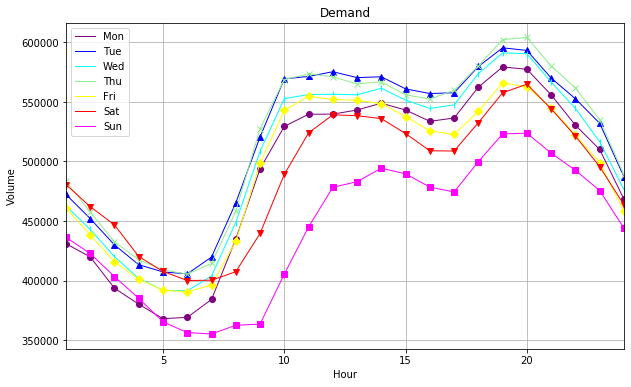

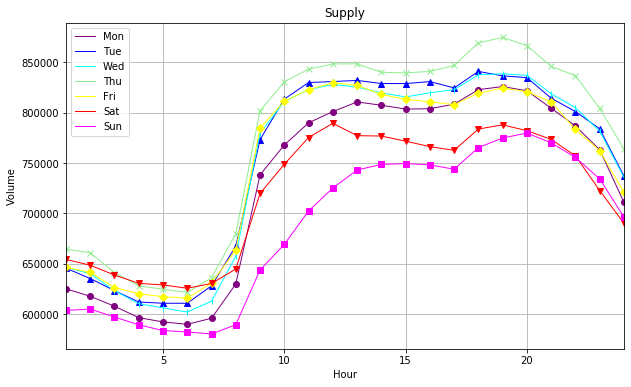

In [870]:
%matplotlib inline
markers = ["o", "^", "|", "x", "D", "v", "s"]
colors = ["purple", "blue", "cyan", "lightgreen", "yellow", "red", "fuchsia", ]

ax1 = hourly_purchase.plot(color=colors, figsize=(10, 6), linewidth=1, grid=True)
for i, line in enumerate(ax1.get_lines()):
    line.set_marker(markers[i])
ax1.set_title("Demand")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Volume")

ax2 = hourly_sell.plot(color=colors, figsize=(10, 6), linewidth=1, grid=True)
for i, line in enumerate(ax2.get_lines()):
    line.set_marker(markers[i])
ax2.set_title("Supply")
ax2.set_xlabel("Hour")
ax2.set_ylabel("Volume")

plt.show()

In [30]:
# # Function to find TimeStepID that is either duplicated (for 25-hour days) or is missing (23-hour days)
# def find_time_step_id(time_step_id_dataframe, data_points):
#     if data_points == 23:
#         for i, time_step_id in enumerate(time_step_id_dataframe):
#             if i+1 < time_step_id:
#                 return(i+1)
#             elif i == data_points:
#                 return(24)
                
#     elif data_points == 25:
#         for i, time_step_id in enumerate(time_step_id_dataframe):
#             if i+1 > time_step_id:
#                 return(time_step_id)

# # Function to interpolate between two demand curves or between two supply curves to create a new curve
# def combine_bids(dataframe, time_step_id, data_points):
#     new_bid_dict = {"DeliveryDay": dataframe["DeliveryDay"].iloc[0]
#                    ,"TimeStepID": time_step_id}
    
#     # If we are interpolating a bid from two different bids, we do so by building the price curves for both hours
#     # and then creating an interpolation between these two curves corresponding to each individual bid. More complicated...
#     if data_points == 23:
#         previous_hour_bids = dataframe.loc[dataframe["TimeStepID"]==time_step_id-1,:]
#         next_hour_bids = dataframe.loc[dataframe["TimeStepID"]==time_step_id+1,:]
        
#         for column in ["PurchaseVolume", "PurchasePrice", "SellVolume", "SellPrice"]:
#             new_bid_data = previous_hour_bids[column].iloc[0] + "," + next_hour_bids[column].iloc[0]
#             new_bid_dict[column] = new_bid_data

#         new_bid = pd.DataFrame(new_bid_dict, index=next_hour_bids.index)
#         return(new_bid)
        
#     # If we are replacing two bid hours with one, we do so by combining the bids between the two into one set of bids.
#     elif data_points == 25:
#         bids = dataframe.loc[dataframe["TimeStepID"]==time_step_id,:]
#         purchase_curve1, sell_curve1 = get_price_curves(dataframe, dataframe.index[0], aggregated=True)
#         purchase_curve2, sell_curve2 = get_price_curves(dataframe, dataframe.index[1], aggregated=True)
        
        
        
#         return(purchase_curve1, purchase_curve2, sell_curve1, sell_curve2)



# def dst_adjustment(dataframe):
#     # Fetch a list of DST days
#     dst_dates = dataframe.groupby("DeliveryDay").count().loc[(dataframe.groupby("DeliveryDay").count() != 24).any(axis=1),"TimeStepID"]
#     n = dst_dates.shape[0]
    
#     # Note: We make a strong assumption that any odd days consist of only either 23 hours or 25 hours. Any other ones
#     # have not yet been accounted for.
#     for i in range(n):
#         i=1
#         date = dst_dates.index[i]
#         data_points = dst_dates[i]
        
#         bids_at_date = dataframe.loc[dataframe["DeliveryDay"] == date,:]
#         time_step_id = find_time_step_id(bids_at_date["TimeStepID"], data_points)
#         combined_bid = combine_bids(bids_at_date, time_step_id, data_points)
        
#         return(combined_bid)

In [31]:
dst_adjustment(ba)

(     PurchaseVolume  PurchasePrice  AggregatedPurchaseVolume
 125          1609.3        3000.00                    1609.3
 124          1609.3         500.11                    3218.6
 123          2276.7         500.11                    5495.3
 122          2276.7         500.00                    7772.0
 121          3058.1         500.00                   10830.1
 120          3058.1         450.00                   13888.2
 119          3129.4         450.00                   17017.6
 118          3129.4         303.19                   20147.0
 117          3163.0         303.19                   23310.0
 116          3163.0         300.00                   26473.0
 115          3168.1         300.00                   29641.1
 114          3168.1         165.00                   32809.2
 113          3176.7         165.00                   35985.9
 112          3176.7         140.00                   39162.6
 111          3191.7         140.00                   42354.3
 110    

### 3. Forecast future bid volumes, reconstruct original price curves, then determine corresponding prices

As indicated in the heading, the steps here are as follows:
1. <b>Use the trained model to forecast future bid volumes:</b> Our model should allow for single-step or multi-step forecasts.
2. <b>Reconstruct original price curves</b>
3. <b> Extract information from reconstructed price curves</b>. This includes, of course, the corresponding electricity price. However, we can also obtain other information from the curves, such as the likelihood of price spikes, reflected in the elasticity (slope) of the price curves.

### Further Points to Improve Upon:
* Optimise the code:
    * The same kinds of data preprocessing is done in several places.
    * Multiple functions are created that do similar things. Might be better to combine these functions into one, e.g. `get_price_curves()` and `to_price_curve()`, although in this case, the outputs are the same but the input and methods are completely different.
* Model Assumptions/Methods:
    * Linear relationship between two price bids, without explicitly including more complmex bids, e.g. block bids.
    * Simple dimension reduction technique (price classes)
    * Daylight saving adjustments: interpolation/averaging
    * Holidays were ignored
    * Restructuring procedure could be improved, i.e. bid reconstruction probabilities, use of Bernoulli r.v., etc.
* Data:
    * As of writing, the dataset we are working with is only ROI data, so excluding NI. We should allow for datasets that contain both kinds of data.
    * We could also further include prices from other markets, since the market coupling process influences the market clearing price (I think).

### Things to ruminate and cogitate during one's free time
* Day of the week effect
* choice of set of day lags
* lasso estimator "is consistent and asymptotic normal for the non-zero parameter components"